In [2]:
import torch
import pytorch_lightning as pl
from models.pi_nets import CCP
from models.neural_nets import FeedForwardNN, PolynomialNN
from data.polynomials import PolynomialGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from torch.distributions.normal import Normal
from utils import model_utils
%load_ext autoreload
%autoreload 2

c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Learning curves

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tb_logs/ --host localhost

# Model Performance

In [52]:
checkpoint = r"tb_logs\PolynomialNN\x3+3x2+5x\one_layer_three_pow\checkpoints\epoch=29-step=1920.ckpt"
model = PolynomialNN.load_from_checkpoint(checkpoint)
polynomial = lambda x: x**3 + 3*x**2 + 5*x

In [53]:
model_utils.count_parameters(model)

193

In [54]:
model

PolynomialNN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): PolynomialActivation()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss): MSELoss()
)

In [55]:
dataloader = PolynomialGenerator(polynomial, 100000)
dataloader.setup("test")
test_dataloader = dataloader.test_dataloader()

In [60]:
scales = range(1, 6)
means = range(0, 5)
plot_dict = {'mu': [],
             'sigma': [],
             'r2': []}
for mu in means:
    for sigma in scales:
        plot_dict['mu'].append(mu)
        plot_dict['sigma'].append(sigma)
        dist = Normal(mu, sigma)
        x = dist.sample((25000,1))
        y = x.clone().apply_(polynomial)
        with torch.no_grad():
            y_hat = model(x)
            plot_dict['r2'].append(r2_score(y, y_hat))
            
df = pd.DataFrame(plot_dict)
data = df.pivot(index="mu", columns="sigma", values="r2")

In [61]:
data

sigma,1,2,3,4,5
mu,,,,,
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


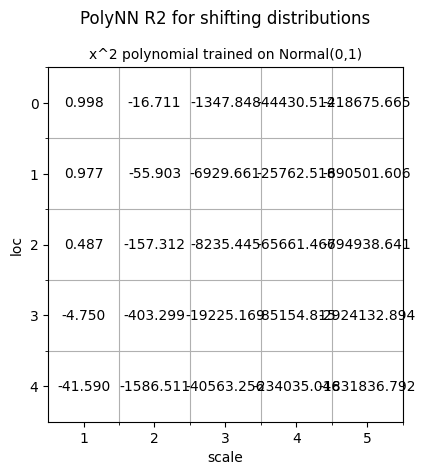

In [49]:
loc = 0
scale = 1
fig, ax = plt.subplots()
ax.set_title("x^2 polynomial trained on Normal(0,1)", fontsize=10)
ax.grid(True, which="minor")
ax.imshow(data, alpha=0)

ax.set_ylabel("loc")
ax.set_xlabel("scale")
ax.set_xticks(np.array(scales)-0.5, minor=True)
ax.set_yticks(np.array(means)-0.5, minor=True)
ax.set_yticklabels([''] + data.index.values.tolist())
ax.set_xticklabels([''] + data.columns.values.tolist())

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.3f}'.format(z), ha="center", va="center")

fig.suptitle("PolyNN R2 for shifting distributions");
fig.tight_layout()
#fig.savefig("imgs/PolyNN_x2_test.png", dpi=600, transparent=True)

R2: 0.9914064752656524


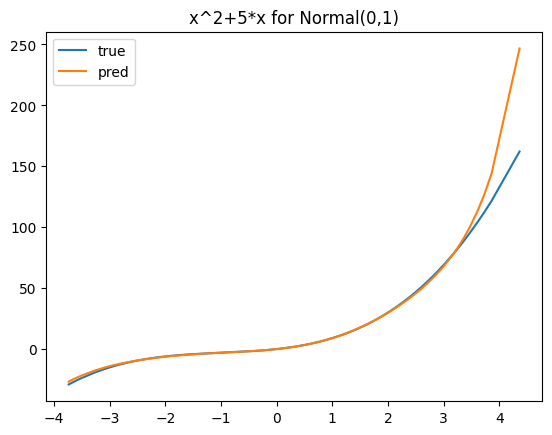

In [50]:
dist = Normal(0, 1)
x = dist.sample((10000,1))
y = x.clone().apply_(polynomial)

with torch.no_grad():
    y_hat = model(x)
    print("R2:", r2_score(y, y_hat))

indices = torch.argsort(x, dim=0).squeeze()
plt.plot(x[indices], y[indices], label="true")
plt.plot(x[indices], y_hat[indices], label="pred")
plt.legend()
plt.title("x^2+5*x for Normal(0,1)");

R2: -152870.5153965726


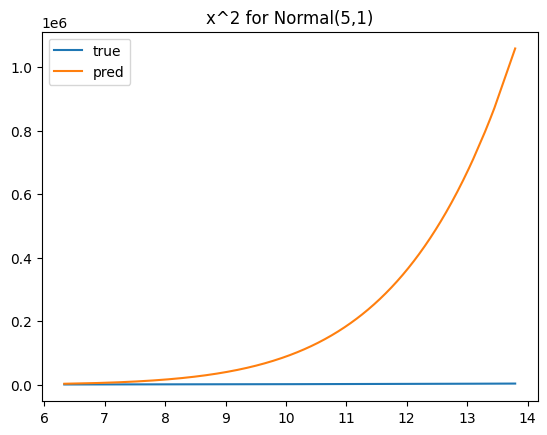

In [51]:
dist = Normal(10, 1)
x = dist.sample((10000,1))
y = x.clone().apply_(polynomial)

with torch.no_grad():
    y_hat = model(x)
    print("R2:", r2_score(y, y_hat))

indices = torch.argsort(x, dim=0).squeeze()
plt.plot(x[indices], y[indices], label="true")
plt.plot(x[indices], y_hat[indices], label="pred")
plt.legend()
plt.title("x^2 for Normal(5,1)");

In [ ]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="feedfoward_x2")
trainer = pl.Trainer(limit_train_batches=64,max_epochs=30, log_every_n_steps=25, logger=logger)
trainer.test(model, dataloaders=dataloader)